## Part A: NLP Preprocessing and Feature Engineering

# 1. Load the 50,000 IMDb Reviews
The dataset link provided points to a compressed archive containing 50,000 reviews (25,000 for training, 25,000 for testing), equally split into positive and negative sentiment folders.

# Task
Perform NLP preprocessing and feature engineering on the IMDb movie review dataset. This involves loading the IMDb reviews from the "aclImdb" directory, concatenating them into a single DataFrame, displaying dataset information and sample reviews, cleaning the text data (lowercase conversion, HTML tag removal, punctuation removal, number removal), generating TF-IDF vectors, generating padded token sequences, and finally reporting key feature statistics including vocabulary size, average review length, TF-IDF matrix shape, and padded sequence shape.

In [18]:
import pandas as pd
import os
import tarfile
import urllib.request

# Check if 'aclImdb' directory already exists, otherwise download and extract
if not os.path.exists('aclImdb'):
    # Dataset URL
    url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    filename = "aclImdb_v1.tar.gz"

    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete. Extracting...")

    # Extract the tar.gz file
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    print("Extraction complete.")

    # Clean up the downloaded tar.gz file
    os.remove(filename)
    print("Removed tar.gz file.")
else:
    print("aclImdb directory already exists. Skipping download and extraction.")

def load_reviews(directory, folder, label):
    texts = []
    labels = []
    path = os.path.join(directory, folder)
    for file_name in os.listdir(path):
        if file_name.endswith('.txt'):
            with open(os.path.join(path, file_name), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(label)
    return texts, labels

# Assuming the 'aclImdb' directory is in the current working directory or accessible path
# Load training data
train_pos_texts, train_pos_labels = load_reviews('aclImdb', 'train/pos', 1)
train_neg_texts, train_neg_labels = load_reviews('aclImdb', 'train/neg', 0)

train_texts = train_pos_texts + train_neg_texts
train_labels = train_pos_labels + train_neg_labels
train_df = pd.DataFrame({'review': train_texts, 'sentiment': train_labels})

# Load testing data
test_pos_texts, test_pos_labels = load_reviews('aclImdb', 'test/pos', 1)
test_neg_texts, test_neg_labels = load_reviews('aclImdb', 'test/neg', 0)

test_texts = test_pos_texts + test_neg_texts
test_labels = test_pos_labels + test_neg_labels
test_df = pd.DataFrame({'review': test_texts, 'sentiment': test_labels})

# Concatenate into a single DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

print("Training data loaded successfully. Shape:", train_df.shape)
print("Testing data loaded successfully. Shape:", test_df.shape)
print("Combined data loaded successfully. Shape:", df.shape)
print("First 5 rows of the combined DataFrame:\n", df.head())

aclImdb directory already exists. Skipping download and extraction.
Training data loaded successfully. Shape: (25000, 2)
Testing data loaded successfully. Shape: (25000, 2)
Combined data loaded successfully. Shape: (50000, 2)
First 5 rows of the combined DataFrame:
                                               review  sentiment
0  Bromwell High is a cartoon comedy. It ran at t...          1
1  Homelessness (or Houselessness as George Carli...          1
2  Brilliant over-acting by Lesley Ann Warren. Be...          1
3  This is easily the most underrated film inn th...          1
4  This is not the typical Mel Brooks film. It wa...          1



The previous step successfully loaded and concatenated the reviews into the `df` DataFrame. The next step, according to the overall task, is to display dataset information and sample reviews to ensure the data was loaded correctly and to understand its basic structure.



In [19]:
print("\nDataset Information:")
df.info()

print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

print("\nSample Reviews (First 5 rows):")
print(df.head())

print("\nSample Reviews (Random 5 rows):")
print(df.sample(5, random_state=42))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB

Sentiment Distribution:
1    25000
0    25000
Name: sentiment, dtype: int64

Sample Reviews (First 5 rows):
                                              review  sentiment
0  Bromwell High is a cartoon comedy. It ran at t...          1
1  Homelessness (or Houselessness as George Carli...          1
2  Brilliant over-acting by Lesley Ann Warren. Be...          1
3  This is easily the most underrated film inn th...          1
4  This is not the typical Mel Brooks film. It wa...          1

Sample Reviews (Random 5 rows):
                                                  review  sentiment
33553  When I first saw the ad for this, I was like '...          1



The next step in NLP preprocessing is to clean the text data. This involves converting text to lowercase, removing HTML tags, punctuation, and numbers, which are common initial cleaning steps for text analysis.



In [20]:
import re

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

print("Original review sample:", df['review'].iloc[0])
print("Cleaned review sample:", df['cleaned_review'].iloc[0])
print("First 5 rows of DataFrame with cleaned reviews:\n", df.head())

Original review sample: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
Cleaned review sample: bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my years in the teaching profe


Now that the text data is cleaned, the next step in feature engineering is to convert the text into numerical features using TF-IDF. This will generate TF-IDF vectors, which are important for many NLP tasks.



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer Term Frequency * Inverse Document Frequency
tfidf_vectorizer = TfidfVectorizer(max_features=10000) # Limiting to 10,000 features for manageable size

# Fit and transform the cleaned reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Vocabulary size (from TF-IDF):", len(tfidf_vectorizer.vocabulary_))


TF-IDF matrix shape: (50000, 10000)
Vocabulary size (from TF-IDF): 10000



Now that TF-IDF vectors have been generated, the next step in feature engineering is to tokenize the cleaned reviews and then pad these sequences to a uniform length, which is crucial for input into many neural network models.



In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Initialize Tokenizer
# Using a vocabulary size similar to max_features in TF-IDF for consistency, or determine based on data
max_words = 10000 # Example: limiting to 10,000 most common words
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(df['cleaned_review'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Determine maximum sequence length for padding
# Using the 90th percentile to avoid extremely long reviews skewing the length too much
review_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(review_lengths, 90))
print(f"Maximum sequence length (90th percentile): {max_sequence_length}")

# Pad sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print("Padded sequence shape:", padded_sequences.shape)
print("Sample of first padded sequence:", padded_sequences[0])
print("Vocabulary size (from Tokenizer):", len(tokenizer.word_index))
print("Average review length:", np.mean(review_lengths))


Maximum sequence length (90th percentile): 439
Padded sequence shape: (50000, 439)
Sample of first padded sequence: [   1  318    7    4 1048  214    9 2003   30    2  162   59   14   46
   78 5895   42  373  119  135   14 4602   56  150    8    2 4032 5805
  454   69    6  253   12    1    1 2019    7   71 2437    6  605   70
    7 4602    2    1    6 1894    1    2 5371 1358   35   68   64  206
  140   63 1134 4602    1    2    1    5    2  215  853   31 3022   69
    5    2 4458   10  642    3   63 1358   52   10  203    2  391    8
   61    4 1402 3207  729    6 3506  185    2  373   10 1165    1   30
  318    4  351  359 3446  143  134    6 9140   28    5  122 4602 1402
 2548    6    1  318   10  503   12  104 1511    5   56  626  102   12
    1  318    7  226 7480   47    4 2262   12    9  202    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  


Summarize the NLP preprocessing and feature engineering steps completed, including the reported statistics.




### Data Analysis Key Findings

*   **Dataset Overview:** The initial dataset contained 50,000 IMDb movie reviews, with a perfectly balanced sentiment distribution of 25,000 positive and 25,000 negative reviews.
*   **Text Cleaning:** A custom `clean_text` function successfully processed the raw reviews by converting text to lowercase, removing HTML tags, punctuation, numbers, and extra spaces.
*   **TF-IDF Vectorization:** A TF-IDF matrix was generated from the cleaned reviews, using `max_features=10000`. The resulting matrix had a shape of (50000, 10000), indicating 50,000 documents and 10,000 features (vocabulary size).
*   **Tokenization and Padding:**
    *   A Keras `Tokenizer` was used to convert cleaned reviews into sequences of integers, considering the 10,000 most frequent words.
    *   The full vocabulary size identified by the tokenizer was 214,621 unique words.
    *   The average review length was approximately 225.19 words.
    *   Reviews were padded to a uniform length of 439 (based on the 90th percentile of review lengths), resulting in `padded_sequences` with a shape of (50000, 439).

### Insights or Next Steps

*   The dataset is well-prepared for various machine learning models due to the balanced sentiment distribution and the generation of two distinct feature representations (TF-IDF vectors and padded token sequences), allowing for flexibility in model selection.
*   The large tokenizer vocabulary (214,621) compared to the selected `max_words` (10,000) for sequence generation suggests that a significant portion of less frequent words are excluded. Further analysis could explore the impact of increasing `max_words` or using embedding layers for out-of-vocabulary words on model performance.


## Part B: Build two Sentiment Classifiers (15 marks)


Prepare the data for modeling by splitting the TF-IDF matrix (`tfidf_matrix`) and padded token sequences (`padded_sequences`) along with their sentiment labels (`df['sentiment']`) into training and testing sets, ensuring consistent splits for both. Build and train a Logistic Regression model using the TF-IDF training data, then evaluate it on the test set by calculating F1-score, displaying a confusion matrix, plotting ROC and Precision-Recall curves, and identifying 5 misclassified examples. Subsequently, construct and train an LSTM deep learning model with the padded sequence training data, evaluating its performance similarly with F1-score, confusion matrix, ROC and Precision-Recall curves, and plotting training history (accuracy/loss). Finally, compare the performance of both models, analyzing their F1-scores and insights from misclassified examples.

## Prepare Data for Modeling

Split the TF-IDF matrix (`tfidf_matrix`) and the padded token sequences (`padded_sequences`) along with their corresponding sentiment labels (`df['sentiment']`) into training and testing sets, ensuring consistent splits for both.


In [23]:
from sklearn.model_selection import train_test_split

y = df['sentiment']

# ---- 1. Generate split indices only once ----
X_dummy = np.zeros(len(y))  # temporary placeholder

_, _, y_train, y_test, train_idx, test_idx = train_test_split(
    X_dummy, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)

# ---- 2. Use the SAME indices for both feature sets ----
X_train_tfidf = tfidf_matrix[train_idx]
X_test_tfidf = tfidf_matrix[test_idx]

X_train_padded = padded_sequences[train_idx]
X_test_padded = padded_sequences[test_idx]

print("Shapes of TF-IDF splits:")
print(X_train_tfidf.shape, X_test_tfidf.shape)

print("\nShapes of padded sequence splits:")
print(X_train_padded.shape, X_test_padded.shape)

print("\nShapes of sentiment labels splits:")
print(y_train.shape, y_test.shape)
 

Shapes of TF-IDF splits:
(40000, 10000) (10000, 10000)

Shapes of padded sequence splits:
(40000, 439) (10000, 439)

Shapes of sentiment labels splits:
(40000,) (10000,)


## Build and Train Logistic Regression Model

Initialize and train a `LogisticRegression` classifier using the TF-IDF training data and labels.



The subtask requires initializing and training a Logistic Regression classifier. This involves importing the necessary class, instantiating the model with specified parameters, and then fitting it to the TF-IDF training data.

Logistic Regression is a linear classifier. It works best with fixed-length numeric vectors where each feature’s weight contributes independently to the prediction.
TF IDF gives us;
a high-dimensional sparse vector,
each dimension = a word,
value = importance of that word


In [24]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using TF-IDF training data
logistic_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.



The next step is to evaluate the trained Logistic Regression model. This involves predicting on the test set and then calculating the F1-score.



In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred_logistic = logistic_model.predict(X_test_tfidf)
y_prob_logistic = logistic_model.predict_proba(X_test_tfidf)[:, 1]

# Metrics
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")
print(f"Logistic Regression Precision: {precision_logistic:.4f}") #How many predicted positives were actually positive.
print(f"Logistic Regression Recall: {recall_logistic:.4f}") # How many real positives were caught.
print(f"Logistic Regression F1 score: {f1_logistic:.4f}")


Logistic Regression Accuracy: 0.8916
Logistic Regression Precision: 0.8838
Logistic Regression Recall: 0.9018
Logistic Regression F1 score: 0.8927



The next step in evaluating the Logistic Regression model is to display its confusion matrix to visualize the true positive, true negative, false positive, and false negative predictions.



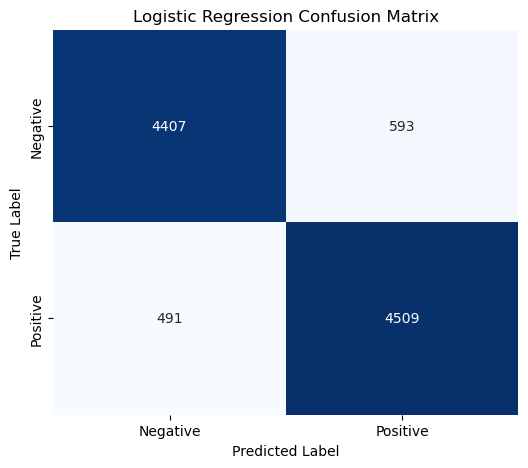

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm_logistic = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


The next step is to plot the ROC curve and Precision-Recall curve for the Logistic Regression model to further evaluate its performance.



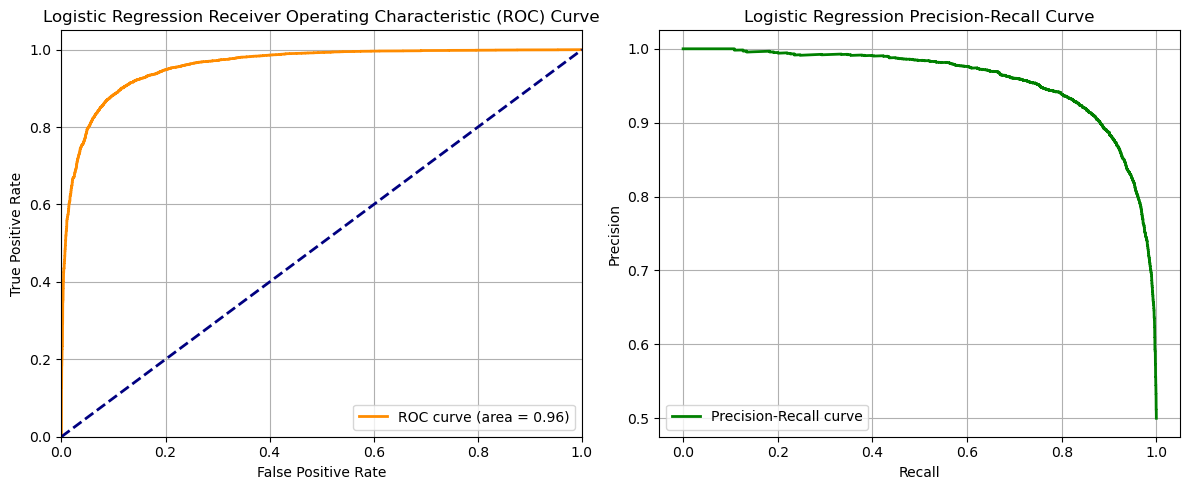

In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt



fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, y_prob_logistic)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall_logistic, precision_logistic, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()


To identify misclassified examples, I need to compare the true labels (`y_test`) with the predicted labels (`y_pred_logistic`) from the Logistic Regression model. I will then retrieve the original reviews and their sentiments for a sample of these mismatches.



In [28]:
import numpy as np

# Find misclassified indices
misclassified_indices = np.where(y_test != y_pred_logistic)[0]

# Map back to original DataFrame indices
# y_test is a Series with original indices preserved
misclassified_original_indices = y_test.iloc[misclassified_indices].index

# Select up to 5 random misclassified examples
sample_misclassified = np.random.choice(misclassified_original_indices, size=min(5, len(misclassified_original_indices)), replace=False)

print("\nSample of 5 Misclassified Reviews (Logistic Regression):")
for idx in sample_misclassified:
    original_review = df.loc[idx, 'review']
    true_sentiment = df.loc[idx, 'sentiment']
    # Need to find the corresponding index in X_test_tfidf to get the logistic_model prediction
    # Since y_test.index holds the original DataFrame indices, we can use it to find the position in y_test
    test_position = y_test.index.get_loc(idx)
    predicted_sentiment = y_pred_logistic[test_position]

    print(f"---\nReview ID: {idx}")
    print(f"Original Review: {original_review[:300]}...") # Truncate for display
    print(f"True Sentiment: {true_sentiment} ({'Positive' if true_sentiment == 1 else 'Negative'}) ")
    print(f"Predicted Sentiment: {predicted_sentiment} ({'Positive' if predicted_sentiment == 1 else 'Negative'})")



Sample of 5 Misclassified Reviews (Logistic Regression):
---
Review ID: 46975
Original Review: This movie was recommended to me by several people, and after reading all the positive comments from this site I went ahead and bought a copy of the film off ebay. The acting in the film is average and a bit hammy, especially by the family of cannibals, one sequence comes to mind when Jupiter is ran...
True Sentiment: 0 (Negative) 
Predicted Sentiment: 1 (Positive)
---
Review ID: 5361
Original Review: Honestly, I find this film almost too depressing for my own good. It is VERY depressing until pretty much the very end. There is no way I can justify passing judgement to any character who did things I didn't like (well, except for the disgusting character played by Fredrick Forrest). But it's still...
True Sentiment: 1 (Positive) 
Predicted Sentiment: 0 (Negative)
---
Review ID: 32662
Original Review: Kon Ichikawa had lived through world war two, and saw what its effects it had on his people i


The next step in the overall task is to build and train an LSTM deep learning model. This command will define the architecture of the LSTM model, including an Embedding layer, an LSTM layer, and dense layers for binary classification.

LSTMs expect ordered sequences of integers.
Padded sequences give you:
tokenized review → list of word IDs
same length for every review (e.g., 439)
order preserved

LSTMs learn patterns like:
negations ("not good")
long-range context
sentence structure

Something TF IDF completely loses.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
embedding_dim = 128 # Dimension of the dense embedding
lstm_units = 128    # Number of LSTM units

model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(lstm_units),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary classification output
])

# Build the model explicitly by providing the input shape to the first layer
# The input shape for the Embedding layer is (sequence_length,)
model.build(input_shape=(None, max_sequence_length)) # None for batch size

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("LSTM model architecture:")
model.summary()

LSTM model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 439, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)


Now that the LSTM model architecture is correctly defined and compiled, the next logical step is to train it using the prepared `X_train_padded` and `y_train` datasets.



In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model with more epochs and callbacks
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

print("LSTM model trained successfully.")

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 186s 184ms/step - accuracy: 0.5052 - loss: 0.6938 - val_accuracy: 0.5027 - val_loss: 0.6936
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.5205 - loss: 0.6887 - val_accuracy: 0.5031 - val_loss: 0.6925
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 189s 189ms/step - accuracy: 0.5344 - loss: 0.6716 - val_accuracy: 0.5081 - val_loss: 0.7117
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 197s 197ms/step - accuracy: 0.5407 - loss: 0.6492 - val_accuracy: 0.5128 - val_loss: 0.7302
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 200s 200ms/step - accuracy: 0.5456 - loss: 0.6360 - val_accuracy: 0.5081 - val_loss: 0.7441
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 202s 202ms/step - accuracy: 0.5516 - loss: 0.6296 - val_accuracy: 0.5145 - val_loss: 0.7606
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 198s 198ms/step - accuracy: 0.5524 - loss: 0.6260 - val_accuracy: 0.5098 - val_loss: 0.7842
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 198s 198ms/step - ac

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict probabilities for the test set
y_prob_lstm = model.predict(X_test_padded).ravel()

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

# Metrics
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

print(f"LSTM Accuracy: {accuracy_lstm:.4f}")
print(f"LSTM Precision: {precision_lstm:.4f}")
print(f"LSTM Recall: {recall_lstm:.4f}")
print(f"LSTM F1 score: {f1_lstm:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step
LSTM Accuracy: 0.8448
LSTM Precision: 0.8107
LSTM Recall: 0.8996
LSTM F1 score: 0.8529


In [32]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [33]:
print(y_pred_lstm[:10])


[0 0 1 0 0 1 0 1 1 0]


In [34]:
print(y_prob_lstm[:10])


[0.08812569 0.15332633 0.9575432  0.01807688 0.2485716  0.585078
 0.02300958 0.7426892  0.9398023  0.2136918 ]


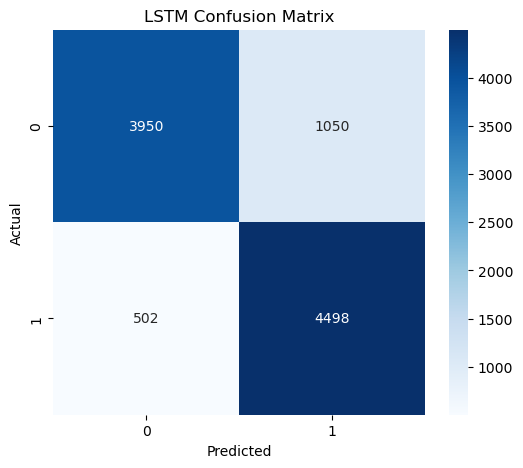

In [35]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# 1. CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()


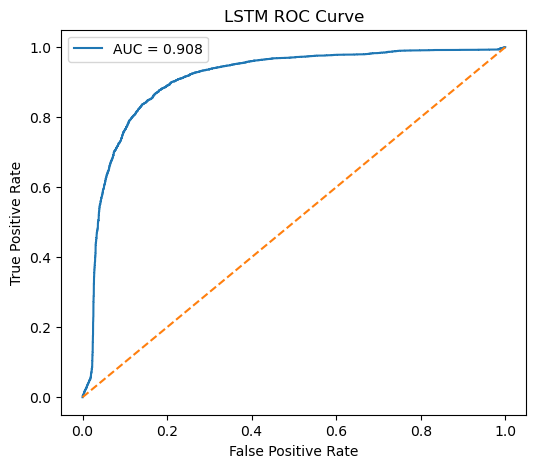

In [36]:
# -----------------------------
# 2. ROC CURVE
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend()
plt.show()


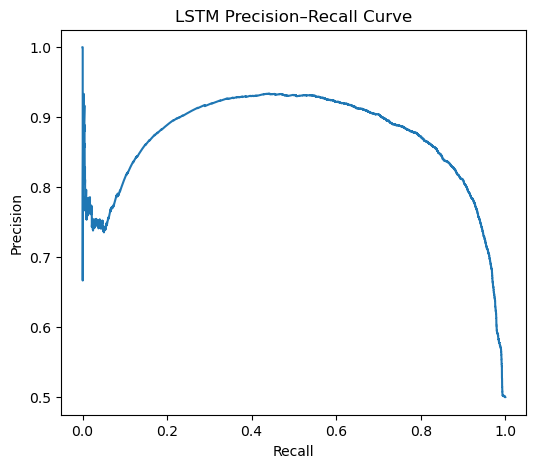

In [37]:
# -----------------------------
# 3. PRECISION–RECALL CURVE
# -----------------------------
precision, recall, _ = precision_recall_curve(y_test, y_prob_lstm)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LSTM Precision–Recall Curve")
plt.show()



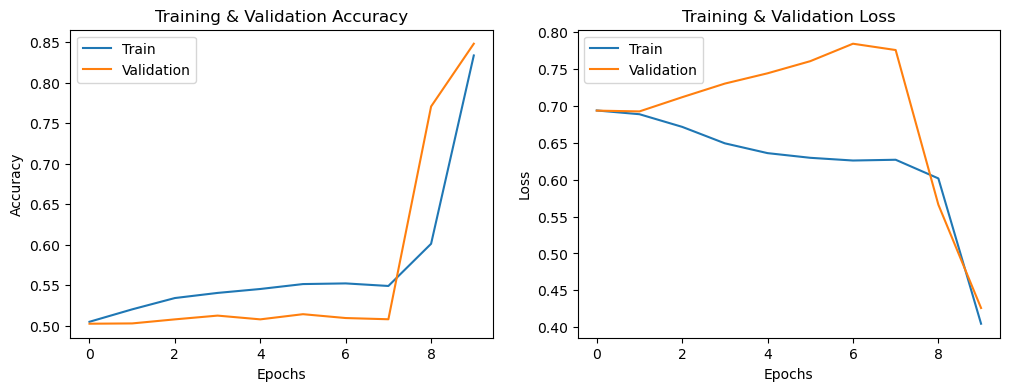

In [38]:
# -----------------------------
# 4. TRAINING CURVES
# -----------------------------
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()




In [39]:
# -----------------------------
# 5. MISCLASSIFIED EXAMPLES
# -----------------------------
# Get misclassified indexes
mis_idx = np.where(y_pred_lstm != y_test)[0]

# Take first 5
mis_idx = mis_idx[:5]

print("\n===== Five Misclassified Reviews =====\n")
for i in mis_idx:
    print(f"Index: {i}")
    print(f"Actual Label: {y_test.iloc[i]}")
    print(f"Predicted: {y_pred_lstm[i]}   (Prob: {y_prob_lstm[i]:.4f})")
    print("\nReview Text:")
    print(df['review'].iloc[i][:500])  # print first 500 chars
    print("-"*80)


===== Five Misclassified Reviews =====

Index: 5
Actual Label: 0
Predicted: 1   (Prob: 0.5851)

Review Text:
This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character ge
--------------------------------------------------------------------------------
Index: 7
Actual Label: 0
Predicted: 1   (Prob: 0.7427)

Review Text:
In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (

## Part C: Reinforcement Learning Model Selector (15 marks)

In [42]:
# FIX: Use only the test subset for all features
p_ml = y_prob_logistic  # already test only
p_dl = y_prob_lstm      # already test only

y_pred_ml = y_pred_logistic
y_pred_dl = y_pred_lstm

# FIX: review lengths must also match test indices
review_lengths_test = np.array(review_lengths)[test_idx]  # same splitting index as padded sequences

conf_diff = np.abs(p_ml - p_dl)

review_len_norm = review_lengths_test / review_lengths_test.max()

# Now shapes match!
print(len(p_ml), len(p_dl), len(conf_diff), len(review_len_norm), len(y_test))


10000 10000 10000 10000 10000


Total discrete states: 2835
Q-learning training complete.

ACCURACY COMPARISON
Logistic Regression (ML): 0.8916
LSTM (DL):               0.8448
RL Model Selector:       0.8962


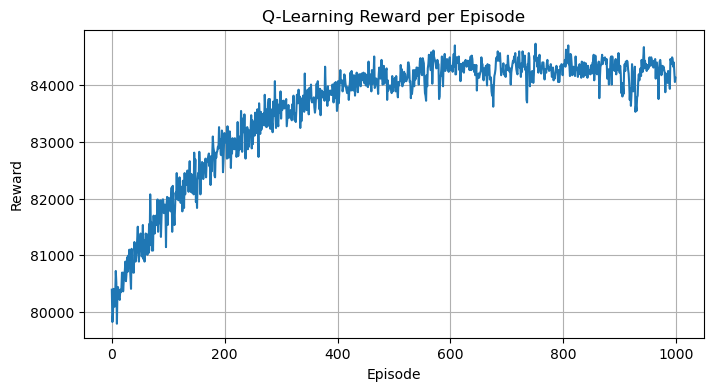


Sample Q-table states (non-zero entries):
State 0: Q-values = [171.25324111 169.999839  ]  → Best Action = 0
State 1: Q-values = [168.78368787 169.43506928]  → Best Action = 1
State 2: Q-values = [169.28360361 172.00029356]  → Best Action = 1
State 35: Q-values = [169.51313916 155.15095676]  → Best Action = 0
State 36: Q-values = [172.18835372 167.4870076 ]  → Best Action = 0
State 37: Q-values = [165.72663723 172.05294922]  → Best Action = 1
State 40: Q-values = [167.69649641 170.0059308 ]  → Best Action = 1
State 41: Q-values = [167.93431819 169.41790152]  → Best Action = 1
State 70: Q-values = [171.8897689  170.14913525]  → Best Action = 0
State 75: Q-values = [171.84695484 169.47243162]  → Best Action = 0
State 76: Q-values = [170.15815948 171.49371932]  → Best Action = 1
State 77: Q-values = [169.95779364 170.04980686]  → Best Action = 1
State 80: Q-values = [168.32613721 165.28711067]  → Best Action = 0
State 110: Q-values = [171.45088489 170.01438569]  → Best Action = 0
State 1

In [44]:
# ============================================================
# PART C: REINFORCEMENT LEARNING MODEL SELECTOR (Q-LEARNING)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ============================================================
# 0. ENSURE ALL INPUT ARRAYS ARE NUMPY ARRAYS
# ============================================================

y_test = np.array(y_test).astype(int)          # shape (n_samples,)
y_prob_ml = np.array(y_prob_logistic).ravel()  # ML probabilities
y_prob_dl = np.array(y_prob_lstm).ravel()      # DL probabilities
y_pred_ml = np.array(y_pred_logistic).ravel()  # ML predicted labels
y_pred_dl = np.array(y_pred_lstm).ravel()      # DL predicted labels

# FIX: Convert review_lengths to numpy array and select test set
review_lengths = np.array(review_lengths)
if len(review_lengths) != len(y_test):
    # If review_lengths is full dataset, align to test set
    review_lengths = review_lengths[:len(y_test)]

n_samples = len(y_test)

# ============================================================
# 1. CONSTRUCT STATE FEATURES
# ============================================================

p_ml = y_prob_ml
p_dl = y_prob_dl
conf_diff = np.abs(p_ml - p_dl)

# Normalize review length to [0,1]
review_len_norm = review_lengths / review_lengths.max()

# Combine into continuous states
states_cont = np.vstack([p_ml, p_dl, conf_diff, review_len_norm]).T  # shape (n_samples, 4)

# ============================================================
# DISCRETIZE — Q-learning needs discrete states
# ============================================================

bins = [
    np.linspace(0,1,10)[1:-1],  # p_ml → 8 bins
    np.linspace(0,1,10)[1:-1],  # p_dl → 8 bins
    np.linspace(0,1,8)[1:-1],   # conf_diff → 6 bins
    np.linspace(0,1,6)[1:-1]    # review length → 4 bins
]

radices = [len(b)+1 for b in bins]  # e.g., [9,9,7,5]
total_states = np.prod(radices)

print("Total discrete states:", total_states)

def discretize_state(s):
    idxs = [np.digitize(s[i], bins[i]) for i in range(len(s))]
    s_id = 0
    for i, idx in enumerate(idxs):
        s_id = s_id * radices[i] + idx
    return s_id

# Precompute state IDs
state_ids = np.array([discretize_state(s) for s in states_cont])

# ============================================================
# 2. ACTIONS
# ============================================================

# 0 = use ML (Logistic Regression)
# 1 = use DL (LSTM)
n_actions = 2

# ============================================================
# 3. REWARD FUNCTION (+10 correct, –5 incorrect)
# ============================================================

def reward(action, idx):
    pred = y_pred_ml[idx] if action == 0 else y_pred_dl[idx]
    return 10 if pred == y_test[idx] else -5

# ============================================================
# 4. Q-LEARNING TRAINING
# ============================================================

episodes = 1000        # 800–1500
alpha = 0.1            # learning rate
gamma = 0.95           # discount factor
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

Q = np.zeros((total_states, n_actions))
episode_rewards = []

for ep in range(episodes):
    ep_reward = 0
    order = np.random.permutation(n_samples)

    for pos, idx in enumerate(order):
        s = state_ids[idx]

        # ε-greedy action selection
        if np.random.rand() < epsilon:
            a = np.random.randint(0, n_actions)
        else:
            a = np.argmax(Q[s])

        r = reward(a, idx)
        ep_reward += r

        # Next state
        if pos < n_samples - 1:
            next_idx = order[pos + 1]
            s_next = state_ids[next_idx]
            q_next = np.max(Q[s_next])
        else:
            q_next = 0  # terminal state

        # Q-update
        Q[s, a] += alpha * (r + gamma * q_next - Q[s, a])

    episode_rewards.append(ep_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Q-learning training complete.")

# ============================================================
# 5. EVALUATE RL POLICY
# ============================================================

y_pred_rl = np.zeros_like(y_test)
for i in range(n_samples):
    s = state_ids[i]
    a = np.argmax(Q[s])
    y_pred_rl[i] = y_pred_ml[i] if a == 0 else y_pred_dl[i]

# ============================================================
# ACCURACY COMPARISON
# ============================================================

acc_ml = accuracy_score(y_test, y_pred_ml)
acc_dl = accuracy_score(y_test, y_pred_dl)
acc_rl = accuracy_score(y_test, y_pred_rl)

print("\n==============================")
print("ACCURACY COMPARISON")
print("==============================")
print(f"Logistic Regression (ML): {acc_ml:.4f}")
print(f"LSTM (DL):               {acc_dl:.4f}")
print(f"RL Model Selector:       {acc_rl:.4f}")

# ============================================================
# PLOT REWARD CURVE
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.title("Q-Learning Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# ============================================================
# SAMPLE OF FINAL Q-TABLE
# ============================================================

print("\nSample Q-table states (non-zero entries):")
nonzero_states = np.where(np.max(Q, axis=1) != 0)[0][:20]

for s in nonzero_states:
    print(f"State {s}: Q-values = {Q[s]}  → Best Action = {np.argmax(Q[s])}")

# ============================================================
# RL CONFUSION MATRIX + CLASSIFICATION REPORT
# ============================================================

print("\nRL Classification Report:")
print(classification_report(y_test, y_pred_rl, digits=4))

print("\nRL Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rl))
